In [1]:
# -*- coding= uft-8 -*-

In [2]:
import pickle
import numpy as np
import sys
import collections

In [3]:
sys.path.append('/home/tf/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages')
import tensorflow as tf
from tqdm import tqdm

/home/tf/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
with open('/home/tf/dl_fun/13_word2Vec/data/wiki.zh.word.text.300maa' , 'rb') as fr:
    lines = fr.readlines()
print('共%d行' % len(lines))
print(lines[0].decode('utf-8', "ignore"))

共61880行
欧几里得 西元前 三 世纪 的 希腊 数学家 现在 被 认为 是 几何 之 父 此画 为 拉斐尔 的 作品 雅典 学院 数学 mathematics 是 利用 符号语言 研究 数量 结构 变化 以及 空间 等 概念 的 一门 学科 从 某种 角度看 属于 形式 科学 的 一种 数学 透过 抽象化 和 逻辑推理 的 使用 由 计数 计算 数学家 们 拓展 这些 概念 对 数学 基本概念 的 完善 早 在 古埃及 而 在 古希腊 那里 有 更为 严谨 的 处理 从 那时 开始 数学 的 发展 便 持续 不断 地 小幅 进展 世纪 的 文艺复兴 时期 致使 数学 的 加速 发展 直至 今日 今日 数学 使用 在 不同 的 领域 中 包括 科学 工程 医学 和 经济学 等 有时 亦 会 激起 新 的 数学 发现 并 导致 全新 学科 的 发展 数学家 也 研究 纯数学 就是 数学 本身 的 实质性 内容 而 不以 任何 实际 应用 为 目标 虽然 许多 研究 以 纯数学 开始 但 其 过程 中 也 发现 许多 应用 之 处 词源 西方 语言 中 数学 一 词源 自于 古希腊 语 的 其有 学习 学问 科学 数学 研究 即使 在 其 语源 内 其 形容词 意思 为 和 学习 有关 的 用功 的 亦 会 被 用来 指 数学 的 其 在 英语 中 表面 上 的 复数 形式 及 在 法语 中 的 表面 复数 形式 可溯 至 拉丁文 的 中性 复数 由 西塞罗 译自 希腊文 复数 此一 希腊语 被 亚里士多德 拿来 指 万物 皆 数 的 概念 数学 一词 的 大约 产生 于 宋元 时期 多指 象数 之学 但 有时 也 含有 今天 上 的 数学 意义 例如 秦九韶 的 数学 九章 永乐 大典 数书 九章 也 被 宋代 周密 所著 的 癸 辛杂识 记 为 数学 大略 数学 通轨 明代 柯尚 迁著 数学 钥 清代 杜知 耕著 数学 拾遗 清代 丁取忠 撰 直到 经过 中国 数学 名词 审查 委员会 研究 算学 数学 两词 的 使用 状况 后 确认 以 数学 表示 今天 意义 上 的 数学 含义 历史 奇普 印加帝国 时所 使用 的 计数 工具 数学 有着 久远 的 历史 中国 古代 的 六艺 之一 就 有 数学 一词 在 西方 有 希腊语 词源 mathematik ó s

In [5]:
import re

In [6]:
zh_pattern = re.compile(u'[\u4e00-\u9fa5]+')
def contain_zh(word):
    '''
    判断传入字符串是否包含中文
    :param word: 待判断字符串
    :return: True:包含中文  False:不包含中文
    '''
    global zh_pattern
    match = zh_pattern.findall(word)
    return match

In [7]:
lines = [line.decode('utf-8' , "ignore") for line in lines ]
words = ' '.join(lines)
words = words.replace('\n', '').split(' ')
words = [word for word in words if len(contain_zh(word)) >=1]
print('共%d个词' % len(words))

共43689887个词


In [8]:
vocab_size = 50000
vocab = collections.Counter(words).most_common(vocab_size - 1)
count = [['UNK', 0]]
count.extend(vocab)
print(count[:10])

[['UNK', 0], ('的', 1862328), ('在', 507911), ('是', 372995), ('年', 314945), ('为', 302192), ('和', 253349), ('了', 244163), ('与', 213124), ('有', 193026)]


In [9]:
word2id = {}
id2word = {}
for i, w in enumerate(count):
    word2id[w[0]] = i
    id2word[i] = w[0]
print(id2word[100], word2id['数学'])

如 791


In [10]:
data = []
for i in tqdm(range(len(lines))):
    line = lines[i].strip('\n').split(' ')
    d = []
    for word in line:
        if word in word2id:
            d.append(word2id[word])
        else:
            d.append(0)
            count[0][1] += 1
    data.append(d)
print('UNK数量%d' % count[0][1])

100%|██████████| 61880/61880 [00:48<00:00, 1282.46it/s]

UNK数量9480115


In [11]:
print(data[0][:10])

[13957, 7789, 274, 129, 1, 1347, 3204, 298, 11, 105]


In [12]:
X_train = []
Y_train = []
window = 3
for i in tqdm(range(len(data))):
    d = data[i]
    for j in range(len(d)):
        start = j - window
        end = j + window
        if start < 0:
            start = 0
        if end >= len(d):
            end = len(d) - 1
        
        while start <= end:
            if start == j:
                start += 1
                continue
            else:
                X_train.append(d[j])
                Y_train.append(d[start])
                start += 1
X_train = np.squeeze(np.array(X_train))
Y_train = np.squeeze(np.array(Y_train))
Y_train = np.expand_dims(Y_train, -1)
print(X_train.shape, Y_train.shape)

100%|██████████| 61880/61880 [05:54<00:00, 174.31it/s]


(286417188,) (286417188, 1)


In [13]:
batch_size = 128
embedding_size = 128
valid_size = 16
valid_range = 100
valid_examples = np.random.choice(valid_range, valid_size, replace=False)
num_negative_samples = 64

In [14]:
X = tf.placeholder(tf.int32, shape=[batch_size], name='X')
Y = tf.placeholder(tf.int32, shape=[batch_size, 1], name='Y')
valid = tf.placeholder(tf.int32, shape=[None], name='valid')

embeddings = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0))
embed = tf.nn.embedding_lookup(embeddings, X)

nce_weights = tf.Variable(tf.truncated_normal([vocab_size, embedding_size], stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocab_size]))

loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights, biases=nce_biases, labels=Y, inputs=embed, num_sampled=num_negative_samples, num_classes=vocab_size))

optimizer = tf.train.AdamOptimizer().minimize(loss)

In [15]:
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm

valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [16]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

offset = 0
losses = []
for i in tqdm(range(100000)):
    if offset + batch_size >= X_train.shape[0]:
        offset = (offset + batch_size) % X_train.shape[0]
        
    X_batch = X_train[offset: offset + batch_size]
    Y_batch = Y_train[offset: offset + batch_size]
    
    _, loss_ = sess.run([optimizer, loss], feed_dict={X: X_batch, Y: Y_batch})
    losses.append(loss_)
    
    if i % 2000 == 0 and i > 0:
        print('Iteration %d Average Loss %f' % (i, np.mean(losses)))
        losses = []
        
    if i % 10000 == 0:
        sim = sess.run(similarity, feed_dict={valid: valid_examples})
        for j in range(valid_size):
            valid_word = id2word[valid_examples[j]]
            top_k = 5
            nearests = (-sim[j, :]).argsort()[1: top_k + 1]
            s = 'Nearest to %s:' % valid_word
            for k in range(top_k):
                s += ' ' + id2word[nearests[k]]
            print(s)
            
    offset += batch_size

  0%|          | 0/100000 [00:00<?, ?it/s]

Nearest to 时: 驻兵 迫 九重 驒 惠州市
Nearest to 开始: 试剂 新婚 老年 梁龙 菩提
Nearest to 年代: 顺利完成 海滩 四弟 双程 三十岁
Nearest to 我: 埃拉 析置 青蛇 义乌 应聘
Nearest to 国家: 孔明 方腊 生铁 琴弦 天书
Nearest to 电影: 平台 主修 尉迟恭 修整 縄
Nearest to 上: 茹 捻 梦里 怒海 招呼
Nearest to 对: 波斯语 药师 二十大 芝山 工作室
Nearest to 则: 神秘 鞑靼 火炎 丽塔 汉高祖
Nearest to 台湾: 学运 杰出 内河 饼干 用水
Nearest to 与: 抱持 之命 不二 鲜师 帕默
Nearest to 号: 书中 重唱 前方 留级 这场
Nearest to 于: 殷墟 死守 宿县 毓 十二五
Nearest to 其他: 亲赴 弦 关露 招降 赞许
Nearest to 以: 一枝梅 藤原 茂密 咨议 期间


  0%|          | 1/100000 [00:36<1026:17:07, 36.95s/it]

Nearest to 美国: 会昌 拉罗 初任 分封 响亮


  2%|▏         | 2002/100000 [05:32<3:37:39,  7.50it/s]

Iteration 2000 Average Loss 228.915253


  4%|▍         | 4002/100000 [09:44<3:11:10,  8.37it/s]

Iteration 4000 Average Loss 164.619720


  6%|▌         | 6002/100000 [13:55<3:10:38,  8.22it/s]

Iteration 6000 Average Loss 131.116028


  8%|▊         | 8002/100000 [18:01<3:05:55,  8.25it/s]

Iteration 8000 Average Loss 107.978928


 10%|█         | 10000/100000 [22:36<3:32:13,  7.07it/s]

Iteration 10000 Average Loss 92.600044
Nearest to 时: UNK 为 和 其中 等
Nearest to 开始: UNK 与 人 在 等
Nearest to 年代: 是 UNK 则 主要 年
Nearest to 我: 国家 出现 中 文化 一个
Nearest to 国家: 年 中国 UNK 于 人
Nearest to 电影: 一个 之 由 但 日本
Nearest to 上: 为 UNK 的 人 等
Nearest to 对: 在 UNK 了 为 年
Nearest to 则: 是 以 UNK 与 等
Nearest to 台湾: 则 中国 在 年 为
Nearest to 与: UNK 是 人 开始 年


 10%|█         | 10001/100000 [22:36<5:19:22,  4.70it/s]

Nearest to 号: 经济 及 国家 此外 UNK
Nearest to 于: 年 中国 有 了 与
Nearest to 其他: 为 在 年 UNK 有
Nearest to 以: UNK 为 则 其中 人
Nearest to 美国: 日本 于 时 等 与


 12%|█▏        | 12002/100000 [27:28<4:37:33,  5.28it/s]

Iteration 12000 Average Loss 76.954460


 14%|█▍        | 14002/100000 [32:08<2:57:49,  8.06it/s]

Iteration 14000 Average Loss 64.658752


 16%|█▌        | 16002/100000 [37:19<2:52:33,  8.11it/s]

Iteration 16000 Average Loss 61.981426


 18%|█▊        | 18002/100000 [41:31<2:42:21,  8.42it/s]

Iteration 18000 Average Loss 53.294876


 20%|██        | 20000/100000 [45:35<2:34:43,  8.62it/s]

Iteration 20000 Average Loss 51.653706
Nearest to 时: 其中 美国 成为 影响 就是
Nearest to 开始: 人 日本 与 则 包括
Nearest to 年代: 则 英国 自 亦 称为
Nearest to 我: 另外 出现 同时 已 文化
Nearest to 国家: 年 中国 于 从 因
Nearest to 电影: 大学 思想 一个 日本 就是
Nearest to 上: 为 的 人 有 UNK
Nearest to 对: 较 向 文化 之 属于
Nearest to 则: 历史 其中 台湾 年代 以
Nearest to 台湾: 则 属于 称为 由于 历史
Nearest to 与: UNK 是 开始 在 年
Nearest to 号: 此外 比较 作为 经济 地
Nearest to 于: 年 中国 国家 了 至
Nearest to 其他: 为 至 有 年 在
Nearest to 以: 其中 UNK 则 为 人


 20%|██        | 20002/100000 [45:36<4:47:51,  4.63it/s]

Nearest to 美国: 日本 时 英国 宗教 至


 22%|██▏       | 22002/100000 [49:27<3:00:32,  7.20it/s]

Iteration 22000 Average Loss 50.833130


 24%|██▍       | 24002/100000 [53:19<2:21:47,  8.93it/s]

Iteration 24000 Average Loss 43.483189


 26%|██▌       | 26002/100000 [57:11<2:42:06,  7.61it/s]

Iteration 26000 Average Loss 36.120182


 28%|██▊       | 28002/100000 [1:01:08<2:17:37,  8.72it/s]

Iteration 28000 Average Loss 35.765167


 30%|███       | 30000/100000 [1:05:39<2:15:02,  8.64it/s]

Iteration 30000 Average Loss 32.363255
Nearest to 时: UNK 为 年 中 和
Nearest to 开始: 并 人 与 UNK 年
Nearest to 年代: UNK 则 是 自 英国


 30%|███       | 30001/100000 [1:05:40<4:15:19,  4.57it/s]

Nearest to 我: 另外 阶段 陆续 区划 出现
Nearest to 国家: 年 UNK 中国 于 了
Nearest to 电影: 公共 话 思想 大学 说法
Nearest to 上: 为 是 有 而 的
Nearest to 对: 在 UNK 了 为 也
Nearest to 则: UNK 是 以 其中 与
Nearest to 台湾: 则 中国 在 年 但
Nearest to 与: UNK 在 是 年 了
Nearest to 号: 比较 此外 简称 据 南北朝
Nearest to 于: 年 UNK 了 在 中国
Nearest to 其他: 为 在 和 有 是
Nearest to 以: UNK 为 则 其中 中
Nearest to 美国: UNK 于 时 日本 是


 32%|███▏      | 32002/100000 [1:09:42<2:12:41,  8.54it/s]

Iteration 32000 Average Loss 28.916862


 34%|███▍      | 34002/100000 [1:13:45<2:09:39,  8.48it/s]

Iteration 34000 Average Loss 29.122417


 36%|███▌      | 36002/100000 [1:17:47<2:05:09,  8.52it/s]

Iteration 36000 Average Loss 24.784409


 38%|███▊      | 38002/100000 [1:21:47<2:00:05,  8.60it/s]

Iteration 38000 Average Loss 24.414614


 40%|████      | 40000/100000 [1:25:51<1:54:35,  8.73it/s]

Iteration 40000 Average Loss 25.547878


 40%|████      | 40002/100000 [1:25:52<4:52:41,  3.42it/s]

Nearest to 时: 为 UNK 中 年 并
Nearest to 开始: 人 与 日本 并 则
Nearest to 年代: 则 是 对 包括 亦
Nearest to 我: 文化 出现 中 另外 国家
Nearest to 国家: 年 中国 于 从 了
Nearest to 电影: UNK 平台 河南省 大学 公共
Nearest to 上: 而 为 研究 下 中
Nearest to 对: 了 在 使用 为 其他
Nearest to 则: 以 其中 台湾 历史 与
Nearest to 台湾: 则 但 中国 由于 研究
Nearest to 与: UNK 是 多 将 和
Nearest to 号: 此外 比较 经济 国家 评论
Nearest to 于: 年 了 国家 UNK 中国
Nearest to 其他: 和 为 在 使用 则
Nearest to 以: UNK 则 为 其中 中
Nearest to 美国: 于 UNK 时 与 日本


 42%|████▏     | 42002/100000 [1:29:52<1:52:28,  8.59it/s]

Iteration 42000 Average Loss 20.569962


 44%|████▍     | 44002/100000 [1:33:51<1:53:03,  8.25it/s]

Iteration 44000 Average Loss 21.599026


 46%|████▌     | 46002/100000 [1:37:53<1:47:24,  8.38it/s]

Iteration 46000 Average Loss 20.443314


 48%|████▊     | 48002/100000 [1:41:56<1:41:02,  8.58it/s]

Iteration 48000 Average Loss 19.717237


 50%|█████     | 50000/100000 [1:46:01<1:50:11,  7.56it/s]

Iteration 50000 Average Loss 19.312160
Nearest to 时: UNK 为 中 其中 国家


 50%|█████     | 50002/100000 [1:46:01<2:31:13,  5.51it/s]

Nearest to 开始: 又 人 由于 日本 目前
Nearest to 年代: 自 则 英国 一 亦
Nearest to 我: 出现 文化 已 另外 同时
Nearest to 国家: 中国 从 因 年 于
Nearest to 电影: UNK 平台 一个 大学 不
Nearest to 上: 研究 国家 具有 就是 下
Nearest to 对: 了 向 文化 出 较
Nearest to 则: 其中 以 又 与 台湾
Nearest to 台湾: 则 由于 但 研究 这种
Nearest to 与: UNK 在 是 和 将
Nearest to 号: 此外 及 比较 国家 经济
Nearest to 于: 年 了 国家 在 UNK
Nearest to 其他: 自己 说 对 使用 作为
Nearest to 以: UNK 其中 为 则 是
Nearest to 美国: 于 UNK 与 时 日本


 52%|█████▏    | 52002/100000 [1:49:58<1:30:30,  8.84it/s]

Iteration 52000 Average Loss 17.485212


 54%|█████▍    | 54002/100000 [1:53:56<1:27:50,  8.73it/s]

Iteration 54000 Average Loss 18.149754


 56%|█████▌    | 56002/100000 [1:57:53<1:22:54,  8.85it/s]

Iteration 56000 Average Loss 16.957762


 58%|█████▊    | 58002/100000 [2:01:54<1:24:16,  8.31it/s]

Iteration 58000 Average Loss 16.709694


 60%|██████    | 60000/100000 [2:06:03<1:18:21,  8.51it/s]

Iteration 60000 Average Loss 17.149921
Nearest to 时: 为 中 并 将 UNK
Nearest to 开始: 由于 目前 并 对 又
Nearest to 年代: 自 则 会议 亦 发达
Nearest to 我: 出现 阶段 另外 同时 已
Nearest to 国家: 中国 在 从 于 因
Nearest to 电影: 平台 UNK 一个 研究 由
Nearest to 上: 中 研究 具有 就是 影响
Nearest to 对: 了 较 向 但 在
Nearest to 则: 其中 历史 逐渐 与 是
Nearest to 台湾: 由于 则 但 研究 组成


 60%|██████    | 60002/100000 [2:06:04<2:03:44,  5.39it/s]

Nearest to 与: 和 UNK 在 是 等
Nearest to 号: 此外 比较 评论 简称 及
Nearest to 于: 在 年 了 国家 中国
Nearest to 其他: 和 为 自己 等 许多
Nearest to 以: 为 其中 则 UNK 但
Nearest to 美国: 于 春秋 日本 发布 与


 62%|██████▏   | 62002/100000 [2:10:09<1:15:13,  8.42it/s]

Iteration 62000 Average Loss 16.509455


 64%|██████▍   | 64002/100000 [2:14:16<1:15:28,  7.95it/s]

Iteration 64000 Average Loss 14.063516


 66%|██████▌   | 66002/100000 [2:18:12<1:04:30,  8.78it/s]

Iteration 66000 Average Loss 14.723403


 68%|██████▊   | 68002/100000 [2:22:16<1:10:12,  7.60it/s]

Iteration 68000 Average Loss 14.083261


 70%|███████   | 70001/100000 [2:26:14<1:29:44,  5.57it/s]

Iteration 70000 Average Loss 14.710823
Nearest to 时: 为 在 和 UNK 并
Nearest to 开始: 并 对 由于 与 在
Nearest to 年代: 世纪 会议 自 则 对
Nearest to 我: 阶段 出现 地质 另外 同时
Nearest to 国家: 在 的 中国 从 有
Nearest to 电影: UNK 平台 的 研究 和
Nearest to 上: 中 研究 方面 是 的
Nearest to 对: 了 在 较 出 但
Nearest to 则: 其中 的 与 是 和
Nearest to 台湾: 则 由于 韩国 组成 为
Nearest to 与: 和 UNK 的 在 是
Nearest to 号: 此外 评论 借口 比较 南北朝
Nearest to 于: 在 年 了 UNK 中国
Nearest to 其他: 和 为 在 自己 等
Nearest to 以: 为 UNK 则 其中 和
Nearest to 美国: 于 与 UNK 和 日本


 72%|███████▏  | 72002/100000 [2:30:39<58:01,  8.04it/s]

Iteration 72000 Average Loss 13.231431


 74%|███████▍  | 74002/100000 [2:37:24<1:45:50,  4.09it/s]

Iteration 74000 Average Loss 12.422188


 76%|███████▌  | 76002/100000 [2:42:22<57:37,  6.94it/s]  

Iteration 76000 Average Loss 13.346236


 78%|███████▊  | 78002/100000 [2:47:19<54:05,  6.78it/s]

Iteration 78000 Average Loss 12.818419


 80%|████████  | 80000/100000 [2:51:53<49:38,  6.72it/s]

Iteration 80000 Average Loss 10.669143


 80%|████████  | 80001/100000 [2:51:57<6:38:00,  1.19s/it]

Nearest to 时: 在 为 和 中 UNK
Nearest to 开始: 在 由于 并 对 的
Nearest to 年代: 世纪 自 则 中 一些
Nearest to 我: 地质 非常 阶段 UNK 出现
Nearest to 国家: 在 中国 的 和 从
Nearest to 电影: UNK 平台 和 的 由
Nearest to 上: 中 的 是 方面 为
Nearest to 对: 在 但 了 也 的
Nearest to 则: 的 是 和 与 其中
Nearest to 台湾: 香港 韩国 由于 中国 则
Nearest to 与: 和 UNK 的 在 是
Nearest to 号: 此外 及 评论 比较 承诺
Nearest to 于: 在 年 了 UNK 中国
Nearest to 其他: 和 等 为 有 在
Nearest to 以: 为 UNK 是 则 的
Nearest to 美国: 于 与 和 约翰 UNK


 82%|████████▏ | 82002/100000 [2:56:23<39:39,  7.56it/s]

Iteration 82000 Average Loss 10.435157


 84%|████████▍ | 84002/100000 [3:00:48<36:10,  7.37it/s]

Iteration 84000 Average Loss 11.618578


 86%|████████▌ | 86002/100000 [3:05:15<31:37,  7.38it/s]

Iteration 86000 Average Loss 11.990019


 88%|████████▊ | 88002/100000 [3:09:50<26:39,  7.50it/s]

Iteration 88000 Average Loss 11.570456


 90%|█████████ | 90001/100000 [3:14:27<29:29,  5.65it/s]

Iteration 90000 Average Loss 10.963706
Nearest to 时: 在 中 和 的 并
Nearest to 开始: 在 并 后 到 由于
Nearest to 年代: 世纪 自 中 发达 则
Nearest to 我: 表示 的 地质 这个 非常
Nearest to 国家: 在 中国 和 的 有
Nearest to 电影: UNK 和 由 的 及
Nearest to 上: 中 的 是 方面 和
Nearest to 对: 在 的 了 但 也
Nearest to 则: 的 是 也 和 等
Nearest to 台湾: 韩国 香港 中国 日本 艺人
Nearest to 与: 和 UNK 的 在 等
Nearest to 号: 此外 评论 成为 前方 借口
Nearest to 于: 在 了 年 的 英国
Nearest to 其他: 和 等 有 的 为
Nearest to 以: 为 是 及 之 则
Nearest to 美国: 日本 和 UNK 英国 于


 92%|█████████▏| 92002/100000 [3:19:02<17:54,  7.44it/s]

Iteration 92000 Average Loss 10.151871


 94%|█████████▍| 94002/100000 [3:23:42<14:04,  7.10it/s]

Iteration 94000 Average Loss 9.681695


 96%|█████████▌| 96002/100000 [3:28:23<09:59,  6.67it/s]

Iteration 96000 Average Loss 9.945853


 98%|█████████▊| 98002/100000 [3:32:57<04:51,  6.84it/s]

Iteration 98000 Average Loss 8.826054


100%|██████████| 100000/100000 [3:37:31<00:00,  5.72it/s]


In [17]:
saver = tf.train.Saver()
saver.save(sess , '/home/tf/dl_fun/13_word2Vec/model/tf_128')
final_embeddings = sess.run(normalized_embeddings)
with open('/home/tf/dl_fun/13_word2Vec/model/tf_128.pkl' ,'wb') as f:
    pickle.dump({'embedding':final_embeddings , 'word2id':word2id , 'id2word':id2word} , f, protocol = 4)

In [18]:
with open('/home/tf/dl_fun/13_word2Vec/model/tf_128.pkl' , 'rb') as f:
    data = pickle.load(f)
    final_embeddings = data['embedding']
    word2id = data['word2id']
    id2word = data['id2word']

获取词频较高的前 200 个非单词，并用 TSNE 降维可视化

In [19]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

plot_only = 200
word_index = []
count = 0

for i in range(1, len(id2word)):
    if len(id2word[i]) >=2:
        word_index.append(i)
        count +=1
        if count == plot_only:
            break

In [20]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embedding = tsne.fit_transform(final_embeddings[word_index ,:])
labels = [id2word[i] for i in word_index]

/home/tf/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


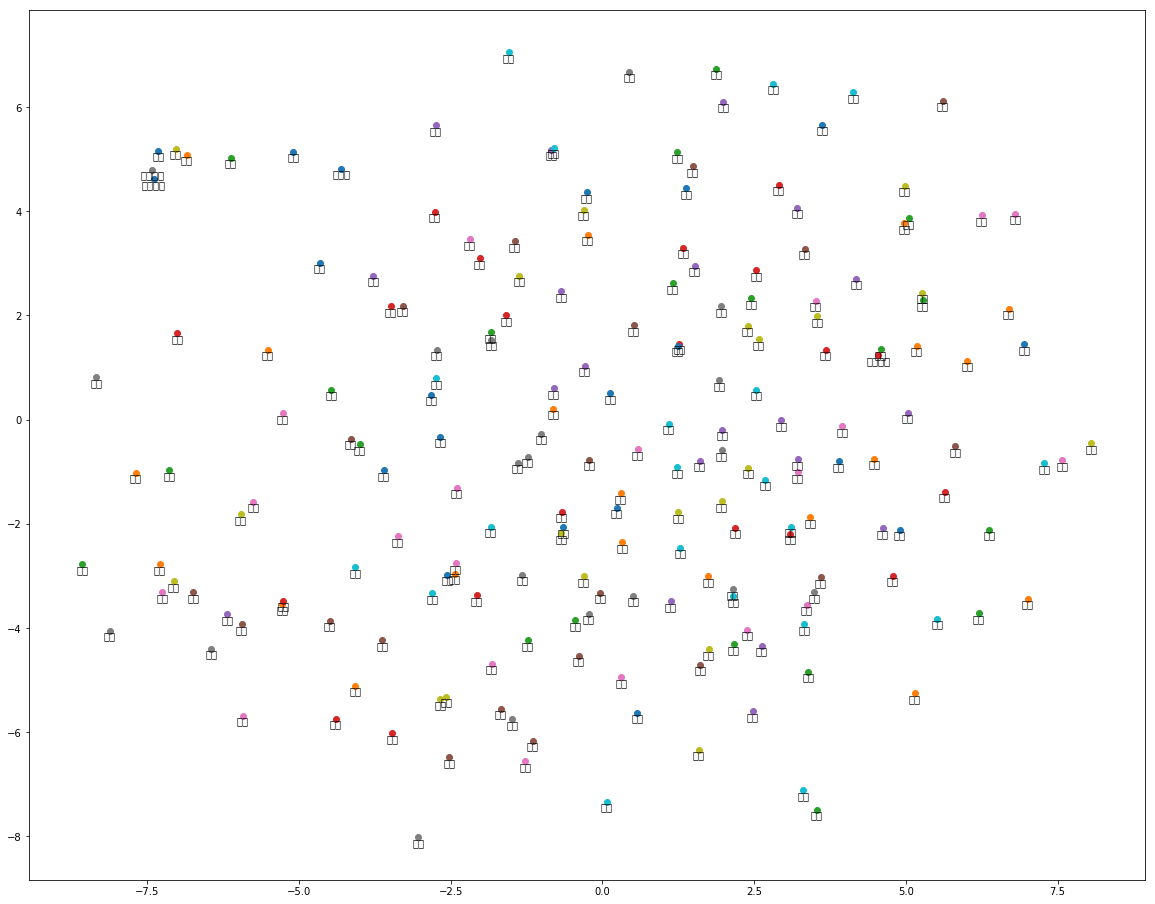

In [48]:
import json

plt.figure(figsize=(20, 16))
for i, label in enumerate(labels):
    x, y = two_d_embedding[i, :]
    plt.scatter(x, y)
    plt.annotate(label.encode('utf-8').decode('utf-8'), (x, y), ha='center', va='top')
plt.savefig('../output/词向量降维可视化.png')

In [49]:
%pwd
%cd /home/tf/dl_fun/13_word2Vec/model/

/home/tf/dl_fun/13_word2Vec/model


In [50]:
saver = tf.train.import_meta_graph('tf_128.meta')
saver.restore(sess, tf.train.latest_checkpoint('.'))
graph = tf.get_default_graph()
valid = graph.get_tensor_by_name('valid:0')
similarity = graph.get_tensor_by_name('MatMul_1:0')

INFO:tensorflow:Restoring parameters from /home/tf/dl_fun/13_word2Vec/model/tf_128


In [55]:
word = '台湾'
sim = sess.run(similarity, feed_dict={valid: [word2id[word]]})
top_k = 10
nearests = (-sim[0, :]).argsort()[1: top_k + 1]
s = 'Nearest to %s:' % word
for k in range(top_k):
    s += ' ' + id2word[nearests[k]]
print(s)

Nearest to 台湾: 韩国 香港 中国 日本 艺人 由于 美国 UNK 以及 以


In [56]:
# 计算相关度
def cal_sim(w1, w2):
    return np.dot(final_embeddings[word2id[w1]], final_embeddings[word2id[w2]])
print(cal_sim('台湾', '香港'))

0.69376063


In [57]:
# 相关词
word = '台湾'
sim = [[id2word[i], cal_sim(word, id2word[i])] for i in range(len(id2word))]
sim.sort(key=lambda x:x[1], reverse=True)
top_k = 10
for i in range(top_k):
    print(sim[i + 1])

['韩国', 0.6960252]
['香港', 0.69376063]
['中国', 0.67613083]
['日本', 0.6654469]
['艺人', 0.642709]
['由于', 0.6381862]
['美国', 0.6368637]
['UNK', 0.62663305]
['以及', 0.61842746]
['以', 0.6181397]


In [58]:
# 不相关词
def find_mismatch(words):
    vectors = [final_embeddings[word2id[word]] for word in words]
    scores = {word: np.mean([cal_sim(word, w) for w in words]) for word in words}
    scores = sorted(scores.items(), key=lambda x:x[1])
    return scores[0][0]
print(find_mismatch(['台湾', '香港', '中国', '数学']))

数学
